# CA684 Machine Learning Assignment Spring 2024

Dublin City University has teamed up with **Etsy** to create the 2024 CA684 Machine Learning assignment.

## Etsy.com

Etsy is the global marketplace for unique and creative goods. It’s home to a universe of special, extraordinary items, from unique handcrafted pieces to vintage treasures. Etsy operates two-sided online marketplaces that collectively connect nearly 100 million passionate and creative buyers and 7.7 million sellers around the world. 

Buyers come to the Etsy marketplace for meaningful, one-of-a-kind items handcrafted and curated with passion and expertise by our creative entrepreneurs. We are focused on attracting potential buyers to Etsy for everyday items that have meaning and those “special” purchase occasions that happen throughout the year. These include items that reflect an individual’s unique style; gifting that demonstrates thought and care; and celebrations that express creativity and fun.

On Etsy, someone searches for …
- Wall art every two seconds
- Wedding-related items every two seconds
- Gift-related items every second
- Antique or vintage items every half a second

## Challenge

Etsy has nearly 100 Million active listings on the etsy.com marketplace for sale from more than 5 million active sellers. You are provided a subset of those products as the training data. 

The task is to leverage the training dataset to learn patterns from and to predict the following attributes on an unseen test dataset given a products’ information:

- top category id
- bottom category id
- primary color id
- secondary color id

The goal is to maximize F1 for each of the classes on each attribute to predict (top category, bottom category, primary color and secondary color). Your approaches and models will be benchmarked against a hidden test dataset.

Bonus points will be given for submissions that:

- the trained model predicts the four attributes at the same time
- visualize some learned representations or embeddings and show that similar items cluster together
- compares the performance of pre-trained embeddings taken from hubs or papers with a fine-tuned model


## Getting Started

Here is some sample code to get you started on the challenge!

Happy Hacking!

### Created By:
### Varun Tiwari
### 23261409
### varun.tiwari2@mail.dcu.ie
### Dublin City University

In [80]:
# libraries
import io
import os
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn import metrics
import tensorflow.compat.v1 as tf2

import pyarrow.parquet as pq

# Matplotlib configuration
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16 }
plt.rc('font', **font)

In [2]:
# set random seed
np.random.seed(seed=42)

## Dataset

The train and test datasets are shared in **parquet** format.

In order to download the dataset, please sign the NDA first.

In [3]:
PATH = r"D:\ML Assignment\data\data\2024\train"

In [141]:
# Get a list of all the Parquet files in the folder
parquet_files = [f for f in os.listdir(PATH) if f.endswith('.parquet')]

In [142]:
# Select the first 50 files or adjust the range accordingly
parquet_files = parquet_files[:50]

In [143]:
parquet_files[:3]

['part-00000-of-00362.parquet',
 'part-00001-of-00362.parquet',
 'part-00002-of-00362.parquet']

In [144]:
test_path = r"D:\ML Assignment\data\data\2024\test"

In [145]:
test_files = [f for f in os.listdir(test_path) if f.endswith('.parquet')]

In [146]:
test_files = test_files[:25]

## Exploratory Data Analysis

### Training Dataset

This dataset can be used to train models and learn patterns from.

In [147]:
# Initialize an empty list to store the data
dataframes = []

# Iterate over each Parquet file and read it into a DataFrame
for file_name in parquet_files:
    file_path = os.path.join(PATH, file_name)
    dataframes.append(pq.read_table(file_path).to_pandas())

# Concatenate all the DataFrames into a single DataFrame and name it as "my_df"
my_df = pd.concat(dataframes, ignore_index=True)

In [148]:
f"Number of rows in train: {len(my_df):,}"

'Number of rows in train: 36,774'

In [149]:
f"Number of unique products in train: {len(my_df['product_id'].unique()):,}"

'Number of unique products in train: 36,774'

In [24]:
f"Number of columns in train: {len(my_df.columns):,}"

'Number of columns in train: 26'

In [150]:
list(my_df.columns)

['product_id',
 'title',
 'description',
 'tags',
 'type',
 'room',
 'craft_type',
 'recipient',
 'material',
 'occasion',
 'holiday',
 'art_subject',
 'style',
 'shape',
 'pattern',
 'bottom_category_id',
 'bottom_category_text',
 'top_category_id',
 'top_category_text',
 'primary_color_id',
 'primary_color_text',
 'secondary_color_id',
 'secondary_color_text',
 'image/encoded',
 'image/width',
 'image/height']

In [26]:
my_df.iloc[0]

product_id                                                      699437355
title                   Children&#39;s circle skirt BLUE GALAXY made o...
description             The fuxandfriends children&#39;s full circle s...
tags                                                                     
type                                                             physical
room                                                                     
craft_type                                                               
recipient                                                                
material                                                                 
occasion                                                                 
holiday                                                                  
art_subject                                                              
style                                                                    
shape                                 

In [27]:
my_df.head(2)

,product_id,title,description,tags,type,room,craft_type,recipient,material,occasion,...,bottom_category_text,top_category_id,top_category_text,primary_color_id,primary_color_text,secondary_color_id,secondary_color_text,image/encoded,image/width,image/height
0,699437355,Children&#39;s circle skirt BLUE GALAXY made o...,The fuxandfriends children&#39;s full circle s...,,physical,,,,,,...,clothing.girls_clothing.skirts,5,clothing,2,blue,2,blue,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,426
1,1323699538,"Cow Birthday Tutu for kids, Farm Theme Bday Ou...",💄This listing is for the TUTU ONLY (double rib...,"birthday outfit,girls birthday shirt,Tutu outf...",physical,,,,,birthday,...,clothing.girls_clothing.skirts,5,clothing,11,pink,1,black,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,475


In [28]:
my_df['type'].unique()

array(['physical', 'download', ''], dtype=object)

In [29]:
my_df['type'].value_counts(dropna=False)

type
physical    34848
download     1889
               37
Name: count, dtype: int64

In [30]:
COLORS = my_df['primary_color_id'].unique()
NUM_COLORS = len(COLORS)
f"Number of primary colors in train: {NUM_COLORS:,}"

'Number of primary colors in train: 19'

In [188]:
COLORS = my_df['secondary_color_id'].unique()
NUM_COLORS = len(COLORS)
f"Number of secondary colors in train: {NUM_COLORS:,}"

'Number of secondary colors in train: 19'

In [31]:
f"Number of top categories in train: {len(my_df['top_category_text'].unique()):,}"

'Number of top categories in train: 15'

In [187]:
f"Number of bottom categories in train: {len(my_df['bottom_category_text'].unique()):,}"

'Number of bottom categories in train: 418'

In [32]:
pd.value_counts(my_df['top_category_text'], sort=True, ascending=False)

top_category_text
home_and_living                8997
clothing                       5839
craft_supplies_and_tools       4190
paper_and_party_supplies       2343
toys_and_games                 2167
weddings                       1978
accessories                    1899
jewelry                        1519
art_and_collectibles           1441
bath_and_beauty                1436
bags_and_purses                1356
books_movies_and_music         1128
electronics_and_accessories     906
shoes                           900
pet_supplies                    675
Name: count, dtype: int64

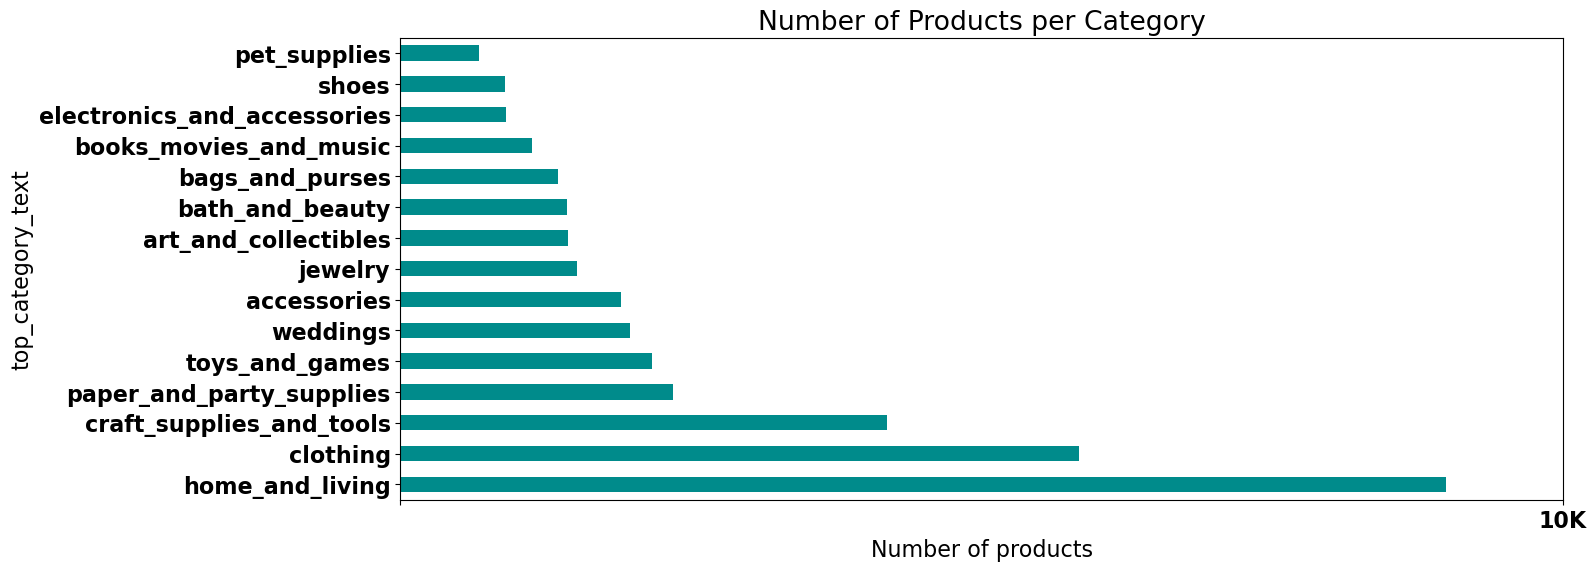

In [34]:
figsize = (15, 6)
column = 'top_category_text'
x_limit = 12000
x_step = 10000
color = 'darkcyan'
    
figure, ax = plt.subplots(figsize=figsize)
pd.value_counts(
    my_df[column], 
    sort=True, ascending=False).plot.barh(color=color)
plt.title(f"Number of Products per Category")
xlabels = [f'{x // 1000:,}K' for x in range(0, x_limit, x_step)]
plt.xticks(range(0, x_limit, x_step), xlabels)
plt.xlabel('Number of products')
plt.setp(ax.get_xticklabels()[0], visible=False)
plt.show()

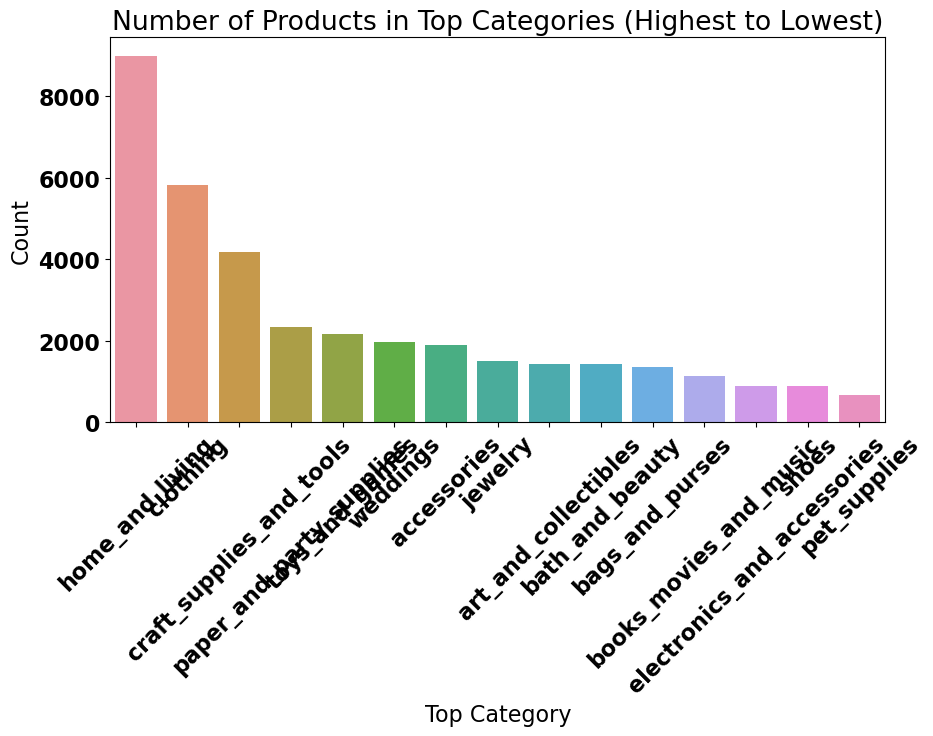

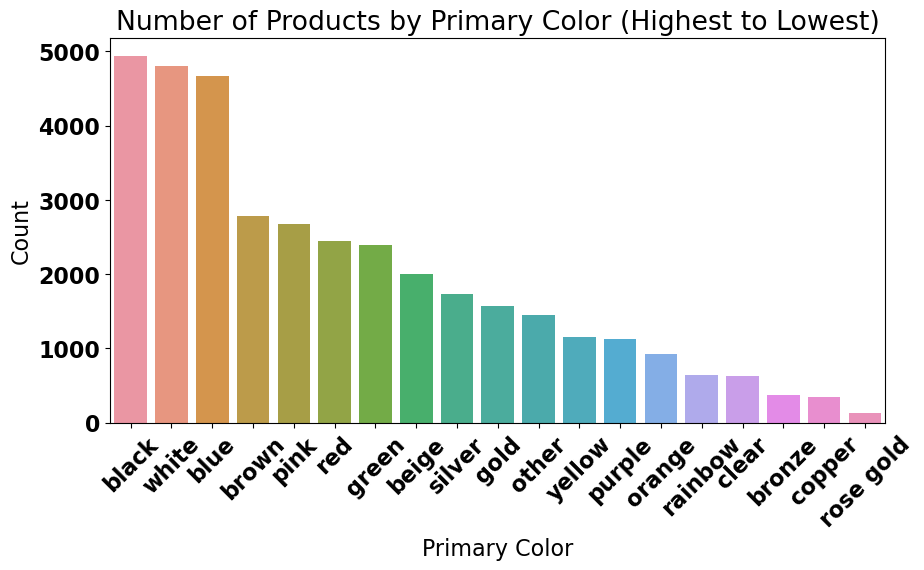

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate counts for each category in 'top_category_text' and 'primary_color_text'
top_category_counts = my_df['top_category_text'].value_counts()
primary_color_counts = my_df['primary_color_text'].value_counts()

# Sort the categories based on counts
top_categories_sorted = top_category_counts.index.tolist()
primary_colors_sorted = primary_color_counts.index.tolist()

# Graph 1: Number of products in 'top_category_text'
plt.figure(figsize=(10, 5))
sns.countplot(data=my_df, x='top_category_text', order=top_categories_sorted)
plt.title('Number of Products in Top Categories (Highest to Lowest)')
plt.xlabel('Top Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Graph 2: Number of products in 'primary_color_text'
plt.figure(figsize=(10, 5))
sns.countplot(data=my_df, x='primary_color_text', order=primary_colors_sorted)
plt.title('Number of Products by Primary Color (Highest to Lowest)')
plt.xlabel('Primary Color')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [35]:
f"Number of bottom categories in train: {len(my_df['bottom_category_text'].unique()):,}"

'Number of bottom categories in train: 418'

In [36]:
def show_images(dataframe, N=100):
    
    num_cols = 5
    num_rows = N // num_cols
    plt_height = 3 * num_rows
    
    plt.figure(figsize=(12, plt_height))
    for i, row in dataframe[:N].iterrows():
        # axis
        ax = plt.subplot(num_rows, num_cols, i + 1)
        # data
        img_bytes = row["image/encoded"]
        label = row["top_category_text"] if "top_category_text" in row else "unknown"
        # image
        bytes_io = io.BytesIO(img_bytes)
        image = Image.open(bytes_io)
        # plot
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image)
        plt.xlabel(label, fontsize = 12)
    plt.show()

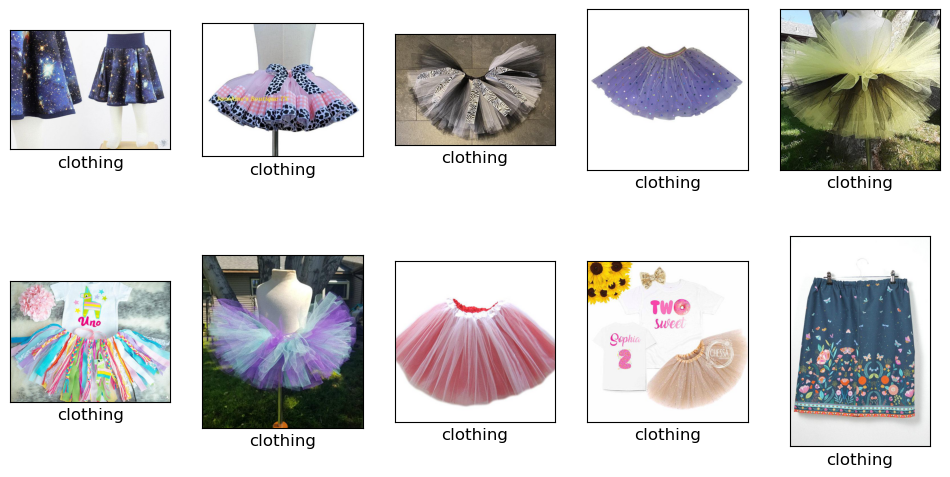

In [37]:
show_images(my_df, 10)

In [91]:
import re

# Define a function to clean a single text column
def clean_text(text):
    # Remove numbers
    text_without_numbers = re.sub(r'\d', '', text)
    # Remove special characters and keep only alphanumeric characters
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text_without_numbers)
    return cleaned_text.strip()  # Strip leading and trailing whitespaces

# Apply the cleaning function to the 'title', 'description', and 'tags' columns
my_df['cleaned_title'] = my_df['title'].apply(clean_text)
my_df['cleaned_description'] = my_df['description'].apply(clean_text)
my_df['cleaned_tags'] = my_df['tags'].apply(clean_text)

# Concatenate the cleaned columns into a single 'merged_data' column
my_df['merged_data'] = my_df['cleaned_title'] + ' ' + my_df['cleaned_description'] + ' ' + my_df['cleaned_tags']

In [92]:
my_df.iloc[0]

product_id                                                      699437355
title                   Children&#39;s circle skirt BLUE GALAXY made o...
description             The fuxandfriends children&#39;s full circle s...
tags                                                                     
type                                                             physical
room                                                                     
craft_type                                                               
recipient                                                                
material                                                                 
occasion                                                                 
holiday                                                                  
art_subject                                                              
style                                                                    
shape                                 

### Test Dataset

The test dataset will be used to predict using the model/s you have trained

**Note** that categories and colors for the test data are hidden, you have to predict them!

In [40]:
# Initialize an empty list to store the data
test_df = []

# Iterate over each Parquet file and read it into a DataFrame
for file_name in test_files:
    file_path = os.path.join(test_path, file_name)
    test_df.append(pq.read_table(file_path).to_pandas())

df_test = pd.concat(test_df, ignore_index=True)

In [41]:
f'Number of rows in test: {len(df_test):,}'

'Number of rows in test: 1,973'

In [42]:
f"Number of unique products in test: {len(df_test['product_id'].unique()):,}"

'Number of unique products in test: 1,973'

In [43]:
f"Number of columns in test: {len(df_test.columns):,}"

'Number of columns in test: 18'

In [44]:
list(df_test.columns)

['product_id',
 'title',
 'description',
 'tags',
 'type',
 'room',
 'craft_type',
 'recipient',
 'material',
 'occasion',
 'holiday',
 'art_subject',
 'style',
 'shape',
 'pattern',
 'image/encoded',
 'image/width',
 'image/height']

In [45]:
df_test.iloc[0]

product_id                                               661373440
title            Classroom Valentine Favors, Valentine Pencils,...
description      Valentine Favors, Robots of Love Vinyl Pencil ...
tags             Valentines day favor,kindergarten treats,valen...
type                                                      physical
room                                                              
craft_type                                            kids' crafts
recipient                                                         
material                                                          
occasion                                                          
holiday                                            valentine's day
art_subject                                                       
style                                                             
shape                                                             
pattern                                                       

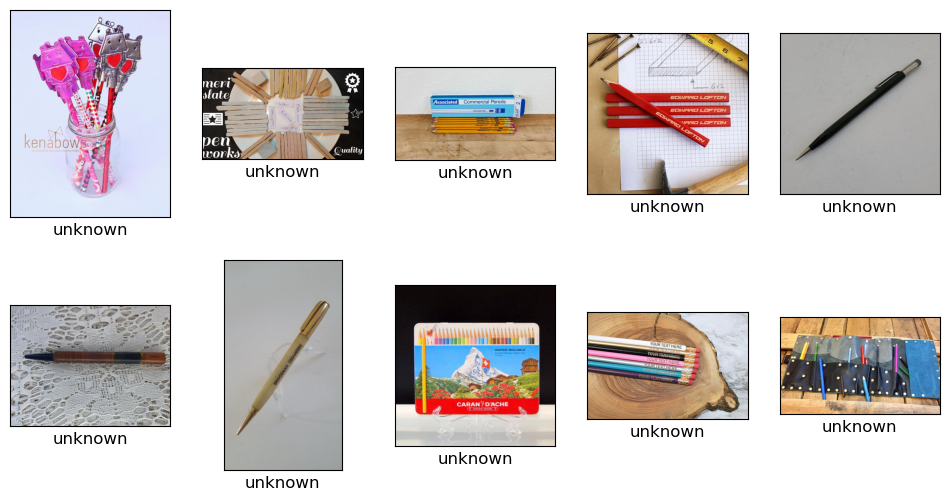

In [46]:
show_images(df_test, 10)

In [47]:
from sklearn.model_selection import train_test_split

my_dfing, df_validation = train_test_split(
    my_df, 
    test_size=0.1, 
    stratify=my_df['bottom_category_text'], 
    random_state=42)

In [48]:
f"Number of products for training: {len(my_dfing):,}"

'Number of products for training: 33,096'

In [49]:
f"Number of products for validation: {len(df_validation):,}"

'Number of products for validation: 3,678'

In [50]:
my_dfing['bottom_category_text'].value_counts()

bottom_category_text
art_and_collectibles.drawing_and_illustration.architectural_drawings                  88
jewelry.earrings.dangle_earrings.chandbalis                                           88
home_and_living.kitchen_and_dining.dining_and_serving.cake_stands                     88
craft_supplies_and_tools.canvas_and_surfaces.paper.collage_sheets                     87
bags_and_purses.cosmetic_and_toiletry_storage.makeup_organizers                       86
                                                                                      ..
craft_supplies_and_tools.tools_and_equipment.parts.tool_parts_and_accessories.burs    43
electronics_and_accessories.parts_and_electrical.sockets_and_wiring                   41
electronics_and_accessories.parts_and_electrical.testing_and_calibration              41
clothing.girls_clothing.baby_girls_clothing.socks_and_leg_warmers                     40
clothing.womens_clothing.pajamas_and_robes.sleep_masks_and_blindfolds.blindfolds      38


In [51]:
df_validation['bottom_category_text'].value_counts()

bottom_category_text
craft_supplies_and_tools.blanks.jewelry                                             10
home_and_living.lighting.light_fixtures.ceiling_lights.chandeliers                  10
clothing.womens_clothing.tops_and_tees.crop_and_tube_tops                           10
jewelry.earrings.dangle_earrings.chandbalis                                         10
bags_and_purses.cosmetic_and_toiletry_storage.makeup_organizers                     10
                                                                                    ..
home_and_living.home_improvement.lighting_parts.plugs_and_cords                      5
electronics_and_accessories.parts_and_electrical.sockets_and_wiring                  5
electronics_and_accessories.parts_and_electrical.testing_and_calibration             4
clothing.girls_clothing.baby_girls_clothing.socks_and_leg_warmers                    4
clothing.womens_clothing.pajamas_and_robes.sleep_masks_and_blindfolds.blindfolds     4
Name: count, Length: 4

In [52]:
my_dfing['top_category_text'].value_counts()

top_category_text
home_and_living                8096
clothing                       5255
craft_supplies_and_tools       3771
paper_and_party_supplies       2108
toys_and_games                 1948
weddings                       1781
accessories                    1710
jewelry                        1369
art_and_collectibles           1296
bath_and_beauty                1292
bags_and_purses                1220
books_movies_and_music         1015
electronics_and_accessories     816
shoes                           810
pet_supplies                    609
Name: count, dtype: int64

In [53]:
df_validation['top_category_text'].value_counts()

top_category_text
home_and_living                901
clothing                       584
craft_supplies_and_tools       419
paper_and_party_supplies       235
toys_and_games                 219
weddings                       197
accessories                    189
jewelry                        150
art_and_collectibles           145
bath_and_beauty                144
bags_and_purses                136
books_movies_and_music         113
electronics_and_accessories     90
shoes                           90
pet_supplies                    66
Name: count, dtype: int64

### Baseline Model

In [54]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [55]:
train_text = my_dfing['title'].fillna('').values

In [56]:
train_labels = my_dfing['top_category_text'].values

In [57]:
text_clf.fit(train_text, train_labels)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

### Text Classification

In [58]:
val_text = df_validation['title'].fillna('').values
val_labels = df_validation['top_category_text'].values

In [60]:
index = 0
print(f"""
Product's title: {val_text[index][:80]}...
Prediction: '{text_clf.predict([val_text[index]])[0]}', Groundtruth: '{val_labels[index]}'
""".strip())

Product's title: Handmade crocheted tote bag...
Prediction: 'home_and_living', Groundtruth: 'bags_and_purses'


In [61]:
df_validation.iloc[0]

product_id                                                     1501707172
title                                         Handmade crocheted tote bag
description             Handmade crocheted tote bag decorated with a r...
tags                    handmade,crocheted handbags,with decorated ros...
type                                                             physical
room                                                                     
craft_type                                                               
recipient                                                                
material                                                                 
occasion                                                                 
holiday                                                                  
art_subject                                                              
style                                                                    
shape                                 

In [62]:
val_text[:1]

array(['Handmade crocheted tote bag'], dtype=object)

In [63]:
predictions = text_clf.predict(val_text)

In [64]:
f1 = metrics.f1_score(val_labels, predictions, average='weighted')

In [66]:
f"F1 score: {f1:.4f}"

'F1 score: 0.6467'

In [67]:
print(metrics.classification_report(val_labels, predictions))

                             precision    recall  f1-score   support

                accessories       0.96      0.46      0.62       189
       art_and_collectibles       1.00      0.13      0.23       145
            bags_and_purses       0.96      0.37      0.53       136
            bath_and_beauty       0.93      0.30      0.45       144
     books_movies_and_music       1.00      0.27      0.42       113
                   clothing       0.72      0.97      0.83       584
   craft_supplies_and_tools       0.78      0.71      0.75       419
electronics_and_accessories       0.97      0.38      0.54        90
            home_and_living       0.52      0.99      0.68       901
                    jewelry       0.85      0.54      0.66       150
   paper_and_party_supplies       0.85      0.71      0.78       235
               pet_supplies       1.00      0.17      0.29        66
                      shoes       1.00      0.30      0.46        90
             toys_and_games      

In [68]:
metrics.confusion_matrix(val_labels, predictions)

array([[ 87,   0,   0,   0,   0,  45,   8,   0,  42,   0,   0,   0,   0,
          0,   7],
       [  0,  19,   0,   0,   0,  10,   2,   1, 105,   0,   1,   0,   0,
          7,   0],
       [  0,   0,  50,   0,   0,   5,   1,   0,  79,   0,   1,   0,   0,
          0,   0],
       [  0,   0,   1,  43,   0,  14,   6,   0,  79,   1,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  30,   9,   9,   0,  60,   0,   5,   0,   0,
          0,   0],
       [  0,   0,   0,   1,   0, 566,   1,   0,  16,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,  12, 299,   0, 105,   0,   3,   0,   0,
          0,   0],
       [  1,   0,   0,   0,   0,   4,   6,  34,  42,   0,   3,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   6,   1,   0, 889,   0,   4,   0,   0,
          0,   1],
       [  2,   0,   0,   0,   0,   8,  24,   0,  34,  81,   0,   0,   0,
          0,   1],
       [  0,   0,   0,   0,   0,   4,   8,   0,  52,   1, 168,   0,   0,
       

In [93]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Concatenate 'tags' and 'title' columns to create combined text
#my_df['text_combined'] = my_df['tags'].fillna('') + ' ' + my_df['title'].fillna('')

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(my_df['merged_data'], my_df['top_category_text'], test_size=0.1, stratify=my_df['top_category_text'], random_state=42)

# Text classification pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

# Train the classifier
text_clf.fit(X_train, y_train)

# Predictions on validation set
predictions = text_clf.predict(X_val)

# Print a sample prediction
index = 0
print(f"""
Product's information: {X_val.iloc[index][:80]}...
Prediction: '{text_clf.predict([X_val.iloc[index]])[0]}', Groundtruth: '{y_val.iloc[index]}'
""".strip())

# Evaluation
f1 = metrics.f1_score(y_val, predictions, average='weighted')
print(f"F1 score: {f1:.4f}")
print(metrics.classification_report(y_val, predictions))
print(metrics.confusion_matrix(y_val, predictions))

Product's title: Natural Block Prints Overalls The Natural Block Prints Overalls are made with  c...
Prediction: 'clothing', Groundtruth: 'clothing'
F1 score: 0.3750
                             precision    recall  f1-score   support

                accessories       1.00      0.06      0.12       190
       art_and_collectibles       1.00      0.01      0.01       144
            bags_and_purses       1.00      0.04      0.07       136
            bath_and_beauty       1.00      0.01      0.01       144
     books_movies_and_music       0.00      0.00      0.00       113
                   clothing       0.82      0.91      0.86       584
   craft_supplies_and_tools       0.94      0.36      0.52       419
electronics_and_accessories       1.00      0.01      0.02        90
            home_and_living       0.33      0.99      0.49       900
                    jewelry       0.80      0.08      0.14       152
   paper_and_party_supplies       0.94      0.21      0.35       234
     

C:\Users\Varun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [95]:
from gensim.models import Word2Vec
import numpy as np
from sklearn.svm import SVC

# Train Word2Vec model on your text data
word2vec_model = Word2Vec(sentences=my_df['merged_data'].apply(lambda x: x.split()), vector_size=100, window=5, min_count=1, workers=4)

# Function to generate word vectors for a text
def generate_word_vectors(text):
    vectors = []
    for word in text.split():
        if word in word2vec_model.wv:
            vectors.append(word2vec_model.wv[word])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)  # Return zero vector if no words found

# Generate word vectors for each text sample
my_df['word_vectors'] = my_df['merged_data'].apply(generate_word_vectors)

# Convert word vectors to numpy array
X = np.stack(my_df['word_vectors'])

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, my_df['top_category_text'], test_size=0.1, stratify=my_df['top_category_text'], random_state=42)

# Train the classifier (using Support Vector Classifier as an example)
clf = SVC()
clf.fit(X_train, y_train)

# Predictions on validation set
predictions = clf.predict(X_val)

# Evaluation
f1 = metrics.f1_score(y_val, predictions, average='weighted')
print(f"F1 score: {f1:.4f}")
print(metrics.classification_report(y_val, predictions))
print(metrics.confusion_matrix(y_val, predictions))

F1 score: 0.6074
                             precision    recall  f1-score   support

                accessories       0.55      0.39      0.46       190
       art_and_collectibles       0.54      0.25      0.34       144
            bags_and_purses       0.56      0.57      0.57       136
            bath_and_beauty       0.78      0.17      0.28       144
     books_movies_and_music       0.71      0.58      0.63       113
                   clothing       0.76      0.95      0.85       584
   craft_supplies_and_tools       0.64      0.51      0.57       419
electronics_and_accessories       0.93      0.28      0.43        90
            home_and_living       0.55      0.88      0.68       900
                    jewelry       0.61      0.53      0.57       152
   paper_and_party_supplies       0.69      0.77      0.73       234
               pet_supplies       1.00      0.19      0.33        67
                      shoes       0.84      0.48      0.61        90
             toy

In [96]:
my_df[['merged_data', 'word_vectors']].head()

,merged_data,word_vectors
0,Childrens circle skirt BLUE GALAXY made of lig...,"[-0.11382269, 0.7979837, 0.62758064, -0.851599..."
1,Cow Birthday Tutu for kids Farm Theme Bday Out...,"[-0.25963145, 1.5536376, 0.86887866, -0.421147..."
2,Zebra print tutu animal print Skirt World book...,"[-0.39791694, 1.2355156, 1.0302128, -0.3981607..."
3,Lilac Tutu Rainbow Dots Girls Tutu Tulle Skir...,"[-0.039471462, 0.5403682, 0.13145436, -0.41671..."
4,Bumblebee tutu yellow and black tutu halloween...,"[-0.362873, 1.3308234, 0.6048245, -0.55371004,..."


In [114]:
from gensim.models import Word2Vec
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Train Word2Vec model on your text data
word2vec_model = Word2Vec(sentences=my_df['merged_data'].apply(lambda x: x.split()), vector_size=100, window=5, min_count=1, workers=4)

# Function to generate word vectors for a text
def generate_word_vectors(text):
    vectors = []
    for word in text.split():
        if word in word2vec_model.wv:
            vectors.append(word2vec_model.wv[word])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)  # Return zero vector if no words found

# Generate word vectors for each text sample
my_df['word_vectors'] = my_df['merged_data'].apply(generate_word_vectors)

# Convert word vectors to numpy array
X = np.stack(my_df['word_vectors'])

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, my_df['bottom_category_text'], test_size=0.1, stratify=my_df['bottom_category_text'], random_state=42)

# Train the classifier (using Support Vector Classifier as an example)
clf = SVC()
clf.fit(X_train, y_train)

# Predictions on validation set
predictions = clf.predict(X_val)

# Evaluation
f1 = f1_score(y_val, predictions, average='weighted')
print(f"F1 score: {f1:.4f}")
print(classification_report(y_val, predictions))
print(confusion_matrix(y_val, predictions))

F1 score: 0.3164
                                                                                                                       precision    recall  f1-score   support

                                                                               accessories.belts_and_suspenders.belts       0.36      0.44      0.40         9
                                                                           accessories.bouquets_and_corsages.bouquets       0.25      0.11      0.15         9
                                                                           accessories.bouquets_and_corsages.corsages       0.29      0.22      0.25         9
                                                                      accessories.costume_accessories.costume_goggles       0.36      0.44      0.40         9
                                                          accessories.costume_accessories.costume_hats_and_headpieces       0.00      0.00      0.00         9
                            

[[4 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 2 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


C:\Users\Varun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Varun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [116]:
from gensim.models import Word2Vec
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Train Word2Vec model on your text data
word2vec_model = Word2Vec(sentences=my_df['merged_data'].apply(lambda x: x.split()), vector_size=100, window=5, min_count=1, workers=4)

# Function to generate word vectors for a text
def generate_word_vectors(text):
    vectors = []
    for word in text.split():
        if word in word2vec_model.wv:
            vectors.append(word2vec_model.wv[word])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)  # Return zero vector if no words found

# Generate word vectors for each text sample
my_df['word_vectors'] = my_df['merged_data'].apply(generate_word_vectors)

# Convert word vectors to numpy array
X = np.stack(my_df['word_vectors'])

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, my_df['bottom_category_text'], test_size=0.1, stratify=my_df['bottom_category_text'], random_state=42)

# Get unique classes from y_train
unique_classes = np.unique(y_train)

# Convert class labels to integers
class_to_int = {cls: i for i, cls in enumerate(unique_classes)}
y_train_int = np.array([class_to_int[cls] for cls in y_train])
y_val_int = np.array([class_to_int[cls] for cls in y_val])

# Train the classifier (using XGBoost)
clf = XGBClassifier()
clf.fit(X_train, y_train_int)

# Predictions on validation set
predictions = clf.predict(X_val)

# Convert predicted integer labels back to original class labels
int_to_class = {i: cls for cls, i in class_to_int.items()}
predictions_class = [int_to_class[i] for i in predictions]

# Evaluation
f1 = f1_score(y_val, predictions_class, average='weighted')
print(f"F1 score: {f1:.4f}")
print(classification_report(y_val, predictions_class))
print(confusion_matrix(y_val, predictions_class))

F1 score: 0.4037
                                                                                                                       precision    recall  f1-score   support

                                                                               accessories.belts_and_suspenders.belts       0.12      0.11      0.12         9
                                                                           accessories.bouquets_and_corsages.bouquets       0.22      0.22      0.22         9
                                                                           accessories.bouquets_and_corsages.corsages       0.44      0.44      0.44         9
                                                                      accessories.costume_accessories.costume_goggles       0.55      0.67      0.60         9
                                                          accessories.costume_accessories.costume_hats_and_headpieces       0.00      0.00      0.00         9
                            

In [101]:
# Print prediction and ground truth for top category
index_top = 0
print(f"""
Top Category Prediction:
Product's title: {val_text[index_top][:80]}...
Prediction: '{predictions_top[index_top]}', Groundtruth: '{y_val_top.iloc[index_top]}'
""".strip())

# Print prediction and ground truth for bottom category
index_bottom = 0
print(f"""
Bottom Category Prediction:
Product's title: {val_text[index_bottom][:80]}...
Prediction: '{predictions_bottom[index_bottom]}', Groundtruth: '{y_val_bottom.iloc[index_bottom]}'
""".strip())

Top Category Prediction:
Product's title: Handmade crocheted tote bag...
Prediction: 'home_and_living', Groundtruth: 'clothing'
Bottom Category Prediction:
Product's title: Handmade crocheted tote bag...
Prediction: 'bags_and_purses.cosmetic_and_toiletry_storage', Groundtruth: 'bags_and_purses.handbags.top_handle_bags'


### Image Processing


In [103]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from PIL import Image
import io
from sklearn.feature_extraction.text import CountVectorizer

# Select 1000 random data points
sample_df = my_df.sample(n=1000, random_state=42)

# Select relevant features
text_features = ['title', 'tags']
image_features = ['image/encoded', 'image/width', 'image/height']

# Process text data
text_data = sample_df[text_features].apply(lambda x: ' '.join(x), axis=1)
vectorizer = CountVectorizer()
X_text = vectorizer.fit_transform(text_data)

# Process image data
X_image = []
target_image_size = (224, 224)  # Standard size for resizing
for img_encoded, img_width, img_height in zip(sample_df['image/encoded'], sample_df['image/width'], sample_df['image/height']):
    img_bytes = io.BytesIO(img_encoded)
    img = Image.open(img_bytes)
    img = img.resize(target_image_size)  # Resize image to standard size
    img_array = np.array(img)
    X_image.append(img_array)
X_image = np.array(X_image)
X_image_flat = X_image.reshape(X_image.shape[0], -1)

# Combine text and image features
X_combined = np.hstack((X_text.toarray(), X_image_flat))

# Target variable
y = sample_df['primary_color_id']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Make predictions
y_pred = dt_classifier.predict(X_test)

# Print prediction and ground truth
for i in range(len(y_test)):
    print("Sample", i+1)
    print("Prediction:", y_pred[i])
    print("Ground Truth:", y_test.iloc[i])
    print()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("F1-score:", f1)

Sample 1
Prediction: 16
Ground Truth: 7

Sample 2
Prediction: 18
Ground Truth: 0

Sample 3
Prediction: 1
Ground Truth: 1

Sample 4
Prediction: 17
Ground Truth: 5

Sample 5
Prediction: 14
Ground Truth: 2

Sample 6
Prediction: 5
Ground Truth: 1

Sample 7
Prediction: 5
Ground Truth: 4

Sample 8
Prediction: 11
Ground Truth: 2

Sample 9
Prediction: 1
Ground Truth: 1

Sample 10
Prediction: 1
Ground Truth: 1

Sample 11
Prediction: 14
Ground Truth: 16

Sample 12
Prediction: 4
Ground Truth: 10

Sample 13
Prediction: 1
Ground Truth: 17

Sample 14
Prediction: 17
Ground Truth: 0

Sample 15
Prediction: 17
Ground Truth: 2

Sample 16
Prediction: 11
Ground Truth: 17

Sample 17
Prediction: 4
Ground Truth: 2

Sample 18
Prediction: 17
Ground Truth: 17

Sample 19
Prediction: 16
Ground Truth: 2

Sample 20
Prediction: 13
Ground Truth: 12

Sample 21
Prediction: 4
Ground Truth: 4

Sample 22
Prediction: 2
Ground Truth: 13

Sample 23
Prediction: 7
Ground Truth: 17

Sample 24
Prediction: 0
Ground Truth: 6

Sampl

In [189]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Select 1000 random data points
sample_df = my_df.sample(n=2000, random_state=42)

# Process image data
X_images = []
target_image_size = (224, 224)  # Standard size for ResNet50
for img_encoded in sample_df['image/encoded']:
    img_bytes = io.BytesIO(img_encoded)
    img = Image.open(img_bytes)
    img = img.resize(target_image_size)
    X_images.append(np.array(img))
X_images = np.array(X_images)

# Preprocess images for ResNet50
X_images = tf.keras.applications.resnet50.preprocess_input(X_images)

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False)

# Extract features using ResNet50
X_features = base_model.predict(X_images)

# Flatten the features
X_features_flat = X_features.reshape(X_features.shape[0], -1)

# Select target variable
y = sample_df['primary_color_id']

# Convert target variable to one-hot encoding
y = to_categorical(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_features_flat, y, test_size=0.2, random_state=42)

# Define a simple classification model
inputs = Input(shape=(X_features_flat.shape[1],))
outputs = Dense(128, activation='relu')(inputs)
outputs = Dense(64, activation='relu')(outputs)
outputs = Dense(32, activation='relu')(outputs)
outputs = Dense(y.shape[1], activation='softmax')(outputs)
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Make predictions
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Convert one-hot encoded labels back to original labels
y_test_labels = np.argmax(y_test, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test_labels, y_pred)
f1 = f1_score(y_test_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("F1-score:", f1)

index = 0
print("Example Prediction and Ground Truth:")
print("Prediction:", y_pred[index])
print("Ground Truth:", y_test_labels[index])

63/63 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step
Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.1194 - loss: 7.8222 - val_accuracy: 0.0875 - val_loss: 2.9933
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.1330 - loss: 2.9874 - val_accuracy: 0.1000 - val_loss: 2.8258
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.2417 - loss: 2.3867 - val_accuracy: 0.1312 - val_loss: 2.7994
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.3300 - loss: 2.0755 - val_accuracy: 0.1875 - val_loss: 3.2995
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.3663 - loss: 1.8748 - val_accuracy: 0.1813 - val_loss: 3.1627
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.4672 - loss: 1.5819 - val_accuracy: 0.1625 - val_loss: 3.2559
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.5394 - loss: 1.4222 - val_accuracy: 0.1875 - val_loss: 2.8748
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.5799 - 

In [192]:
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,568,542 (147.13 MB)

 Trainable params: 12,856,180 (49.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,712,362 (98.08 MB)

In [112]:
print((sample_df['primary_color_id'].unique()))

[ 9 14  1  7 19  0 11 18  4  6  2 13 16 17 12  3 10  5 15]


### Predicting All 4 Attributes

In [152]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np


features = ['title','tags']
targets = ['top_category_id', 'bottom_category_id', 'primary_color_id', 'secondary_color_id']

X_test = test_df[features]
y_test = test_df[targets]

X = my_df[features]
y = my_df[targets]
categorical_cols = [col for col in features if my_df[col].dtype == "object"]
text_cols = ['title', 'tags']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('text_title', TfidfVectorizer(max_features=10000), 'title'),
        ('text_tags', TfidfVectorizer(max_features=10000), 'tags')
    ],
    remainder='passthrough'
)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
model = MultiOutputClassifier(RandomForestClassifier(n_estimators=10))
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

# Custom evaluation function for multi-output classification
def evaluate_accuracy_and_f1_multioutput(y_true, y_pred, target_names):
    accuracies = []
    f1_scores = []
    for i, target_name in enumerate(target_names):
        accuracy = accuracy_score(y_true[:, i], y_pred[:, i])
        f1 = f1_score(y_true[:, i], y_pred[:, i], average='weighted')
        accuracies.append(accuracy)
        f1_scores.append(f1)
        print(f"{target_name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    return accuracies, f1_scores

# Convert the multi-output targets and predictions to numpy arrays for compatibility
y_val_np = np.array(y_val)
y_pred_np = np.array(y_pred)

# Define names for target variables
target_names = ['Top Category', 'Bottom Category', 'Primary Color', 'Secondary Color']

# Evaluate the model
accuracies, f1_scores = evaluate_accuracy_and_f1_multioutput(y_val_np, y_pred_np, target_names)

# Optionally, print the average accuracy and F1 score
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Average F1 Score: {np.mean(f1_scores):.4f}")

Top Category - Accuracy: 0.8265, F1 Score: 0.8233
Bottom Category - Accuracy: 0.7075, F1 Score: 0.7021
Primary Color - Accuracy: 0.4349, F1 Score: 0.4274
Secondary Color - Accuracy: 0.2972, F1 Score: 0.2911
Average Accuracy: 0.5666
Average F1 Score: 0.5610


In [161]:
import pandas as pd

# Assuming 'test_df' is a list of DataFrames containing your test data
# Concatenate the DataFrames into a single DataFrame
test_df = pd.concat(test_df, ignore_index=True)

# Now 'test_df' is a single DataFrame containing your test data

# Assuming 'test_df' contains your test data
X_test = test_df[features]

# Predict on the test data
y_pred_test = pipeline.predict(X_test)

# Optionally, print the predictions
print("Predictions on Test Data:")
print(y_pred_test)

# Append the predicted target attributes to the test_df DataFrame
for i, target in enumerate(targets):
    test_df[target] = y_pred_test[:, i]

# Now 'test_df' contains the predicted target attributes
print("Test DataFrame with Predicted Target Attributes:")
print(test_df)

Predictions on Test Data:
[[   10   145    14    11]
 [    6 11195     9    18]
 [    8   965     1     4]
 ...
 [    6   917    11     2]
 [    8   917    17    17]
 [   13   917     1     0]]
Test DataFrame with Predicted Target Attributes:
      product_id                                              title  \
0      661373440  Classroom Valentine Favors, Valentine Pencils,...   
1     1501009290        5 Colour Slatepencils In One Pack Order NOw   
2     1105447030  No 2 Pencils by Associated Commercial,  #2 Wri...   
3     1140081090  Personalized Carpenter Pencils, Engraved Carpe...   
4      793448890  Vintage 1960&#39;s Autopoint mechanical pencil...   
...          ...                                                ...   
1968  1378743720  All Seasons Lightweight Comforter with Abstrac...   
1969  1646628460  Vintage 90s Looney Tunes Twin Comforter Cover ...   
1970  1632346210  Vintage Ralph Lauren Sinclair Full Queen Comfo...   
1971  1530403430  Blue and White Toile Quilted 

## Submission

In [184]:
df_predictions = test_df.copy()

In [185]:
df_predictions.head(4)

,product_id,title,description,tags,type,room,craft_type,recipient,material,occasion,...,style,shape,pattern,image/encoded,image/width,image/height,top_category_id,bottom_category_id,primary_color_id,secondary_color_id
0,661373440,"Classroom Valentine Favors, Valentine Pencils,...","Valentine Favors, Robots of Love Vinyl Pencil ...","Valentines day favor,kindergarten treats,valen...",physical,,kids' crafts,,,,...,,,,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,739,10,145,14,11
1,1501009290,5 Colour Slatepencils In One Pack Order NOw,5 Colour Slatepencils In One Pack Order NOw\n\...,"slatepencils,clay,nakumatt,edibleclay",physical,,drawing & drafting,,,,...,,,,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,321,6,11195,9,18
2,1105447030,"No 2 Pencils by Associated Commercial, #2 Wri...","This listing is for a dozen, unused pre sharpe...","Faber Castell,aw faber,Faber-Castell,antique p...",physical,,drawing & drafting,,,,...,,,,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,330,8,965,1,4
3,1140081090,"Personalized Carpenter Pencils, Engraved Carpe...",EtchThisOut is now offering Carpenter Pencils ...,"Personalized Pencils,Carpenter Pencils,Carpent...",physical,,drawing & drafting,,,birthday,...,,,,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,570,3,965,4,1


In [186]:
student_id = "23261409"
df_predictions[
    ["product_id", "top_category_id", "bottom_category_id", "primary_color_id", "secondary_color_id"]
].to_parquet(f"predictions_{student_id}.parquet")